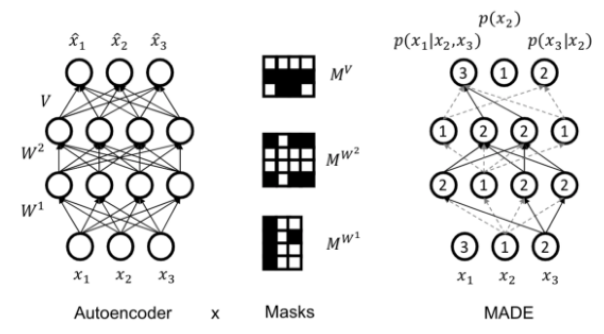

**MADE (Masked Autoencoder for Distribution Estimation)**.

---

### 🔹 Challenge

We want an **autoregressive model** (factorized as a product of conditionals):

$$
p(x_1, x_2, x_3) = p(x_1) p(x_2|x_1) p(x_3|x_1,x_2)
$$

But if we use a **standard autoencoder (fully connected MLP)**, each output $p(x_i)$ might depend on *all* inputs (including future ones), which **breaks autoregressivity**.

---

### 🔹 MADE’s Solution: Masking

* Use **binary masks** on the weights of the network to **forbid illegal connections**.
* These masks enforce that:

  * The output for $x_i$ only depends on inputs $x_{<i}$.
  * No “future” variable leaks into conditionals.

---

### 🔹 Example

Ordering: $x_2, x_3, x_1$.
So factorization is:

$$
p(x_1, x_2, x_3) = p(x_2) \, p(x_3|x_2) \, p(x_1|x_2, x_3)
$$

* Output unit for $p(x_2)$: must depend on **no inputs**.
* Output for $p(x_3|x_2)$: must depend only on $x_2$.
* Output for $p(x_1|x_2, x_3)$: can depend on $x_2, x_3$.

Masks are applied to weight matrices to enforce this.

---

### 🔹 Mask construction

* Each unit (in hidden or output layers) is assigned an integer label $m$.
* Rule: a unit in layer $l$ can only connect to units in layer $l-1$ with **smaller or equal labels**.
* In the **final layer** (outputs), the mask is **strictly smaller**.
* This guarantees autoregressivity for any chosen variable ordering.

---

### 🔹 Big Picture

* **MADE = Autoencoder + Masks**
* It gives us the **efficiency of a feedforward network** while preserving the **autoregressive factorization**.
* Key advantage: unlike FVSBN or NADE, we don’t explicitly unroll conditionals; we just enforce autoregressive structure with masks.

---

✅ **Summary**

* Standard MLP → breaks autoregressive property (future variables leak in).
* MADE → applies masks to ensure each output only depends on allowed inputs.
* Equivalent to NADE but implemented more efficiently.

---


In [1]:
# MADE (Bernoulli) for binary vectors like MNIST (28*28 = 784)
# Paper: Germain et al., 2015 — Masked Autoencoder for Distribution Estimation

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils

---

# What the class is

`MaskedLinear` is a drop-in replacement for `nn.Linear` that **zeroes out specific weights** at every forward pass. It behaves like a dense linear layer, except connections where the mask is 0 are hard-disabled.

```python
class MaskedLinear(nn.Linear):
```

* Inherits all the usual bits from `nn.Linear`: parameters `weight` (shape `[out_features, in_features]`) and optional `bias` (shape `[out_features]`), initialization, `.to()`, etc.

---

# Constructor

```python
def __init__(self, in_features, out_features, bias=True):
    super().__init__(in_features, out_features, bias)
    self.register_buffer("mask", torch.ones(out_features, in_features))
```

* `super().__init__` creates:

  * `self.weight`: `nn.Parameter` with shape `(out_features, in_features)`
  * `self.bias`: `nn.Parameter` with shape `(out_features,)` (or `None`)
* `register_buffer("mask", ...)` adds a **non-trainable tensor** to the module:

  * It’s **saved** in the state dict and **moves** with `.to(device)`/`.cuda()`/`.cpu()`.
  * It is **not** an `nn.Parameter`, so the optimizer won’t try to update it.
  * Initialized to all **ones** (no masking yet). Shape matches the weight.

Why a buffer and not a normal attribute?

* Buffers are tracked and moved with the model; plain attributes aren’t.
* We don’t want gradients for the mask.

---

# Setting / updating the mask

```python
def set_mask(self, mask: torch.Tensor):
    # mask shape: (out_features, in_features)
    self.mask.data.copy_(mask)
```

* Copies the provided mask into the stored buffer **in place**.
* Expected shape matches `weight`; typically dtype float (`0.` or `1.`), but `bool`/`int` will auto-cast when multiplied.

⚠️ Minor API nuance: `tensor.data.copy_(...)` works, but the safer modern idiom is:

```python
with torch.no_grad():
    self.mask.copy_(mask)
```

(avoids touching `.data` directly).

You’d call this whenever you (re)build MADE’s connectivity masks for a new variable ordering.

---

# Forward pass

```python
def forward(self, x):
    return F.linear(x, self.weight * self.mask, self.bias)
```

* `F.linear(x, W, b)` computes `x @ W.T + b`.
* Here we pass `W_eff = self.weight * self.mask` (Hadamard/elementwise product).

  * Entries where `mask == 0` behave as if that weight were **exactly zero**.
  * Entries where `mask == 1` behave normally.
* Shapes:

  * `x`: `(batch, in_features)`
  * `weight * mask`: `(out_features, in_features)`
  * output: `(batch, out_features)`

```

This is the core building block that allows MADE to be “just an MLP” whose wiring obeys autoregressive constraints.


In [2]:
# ---------- Masked Linear -----------------------------------------------------

class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer("mask", torch.ones(out_features, in_features))

    def set_mask(self, mask: torch.Tensor):
        # mask shape: (out_features, in_features)
        self.mask.data.copy_(mask)

    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)

# High-level purpose

`MADE` is an **autoregressive Bernoulli density estimator** implemented as a masked MLP. Masks on each linear layer **forbid illegal connections** so that the logit for variable $x_i$ depends only on $x_{<i}$ (for some ordering). This lets you compute all $D$ Bernoulli conditionals with **one forward pass**.

---

## Constructor (`__init__`)

```python
class MADE(nn.Module):
    def __init__(self, input_dim, hidden_dims=(512, 512), natural_order=True, activation="relu"):
```

* `input_dim (D)`: number of binary variables (e.g., `28*28` for binarized MNIST).
* `hidden_dims`: widths of each hidden layer; you get an MLP with `len(hidden_dims)` hidden layers.
* `natural_order`: if `True`, variable order is $x_1,\dots,x_D$; else a random permutation is used (re-sampled in `resample_masks`).
* `activation`: choice of nonlinearity for hidden layers (`ReLU`, `Tanh`, or `SiLU` here).

```python
super().__init__()
self.D = input_dim
self.hidden_dims = list(hidden_dims)
self.natural_order = natural_order
```

* Stores structural hyperparameters.

```python
if activation == "relu":
    self.act = nn.ReLU()
elif activation == "tanh":
    self.act = nn.Tanh()
else:
    self.act = nn.SiLU()
```

* Selects the hidden activation operator; outputs remain **linear** because output logits will be fed to Bernoulli likelihood.

```python
hs = [self.D] + self.hidden_dims + [self.D]
self.net = nn.ModuleList()
for h0, h1 in zip(hs[:-1], hs[1:]):
    self.net.append(MaskedLinear(h0, h1))
self.resample_masks()
```

* `hs` is the layer size schedule: `[D, H1, H2, ..., HD, D]`.
* Builds a stack of `MaskedLinear` layers (custom linear layer that multiplies weights by a binary mask on every forward).
* Immediately calls `resample_masks()` to **construct and install masks** consistent with the chosen variable ordering.

---

## Mask sampling (the “degree trick”)

```python
def resample_masks(self):
    D = self.D
    L = len(self.hidden_dims)
```

* Convenience aliases.

### 1) Choose input ordering $m^0$

```python
if self.natural_order:
    m_input = torch.arange(1, D + 1)
else:
    m_input = torch.randperm(D) + 1
```

* `m_input` is a vector of **degrees** for the input layer. Degrees are integers in $\{1,\dots,D\}$.
* If `natural_order`, `m_input = [1,2,...,D]` (the identity ordering).
* Else a random permutation (still in $\{1,\dots,D\}$).
  Intuition: a **smaller degree** means an **earlier** variable in the autoregressive order.

### 2) Assign degrees to hidden layers

```python
degrees = [m_input]
for H in self.hidden_dims:
    degrees.append(torch.randint(1, D, (H,)))  # [1..D-1]
```

* Each hidden unit $h^{(\ell)}_k$ gets a degree in $\{1,\dots,D-1\}$.
* Interpretation (MADE rule): a hidden unit with degree $d$ may only depend on inputs with degree $\le d$ (so it summarizes the first $d$ inputs).

### 3) Output layer degrees

```python
m_output = m_input
degrees.append(m_output)
```

* Output units correspond one-to-one with inputs; they inherit the same degrees $m^L = m^0$.
  This will allow us to enforce the **strict** inequality in the final mask so output $i$ cannot depend on $x_i$ itself.

### 4) Build masks for each linear layer

```python
masks = []
for l, layer in enumerate(self.net):
    m_in  = degrees[l]       # previous layer degrees
    m_out = degrees[l + 1]   # current layer degrees

    if l < len(self.net) - 1:
        # hidden layer: allow connections if m_in <= m_out
        mask = (m_out[:, None] >= m_in[None, :]).float()
    else:
        # output layer: enforce strictly < so output i can't depend on x_i
        mask = (m_out[:, None] > m_in[None, :]).float()

    masks.append(mask)
    layer.set_mask(mask)
```

* Each mask has shape `(out_features, in_features)`.
* **Hidden layers**: $W^{(\ell)}_{jk}$ is allowed iff $m^{(\ell)}_j \ge m^{(\ell-1)}_k$.
  Meaning a hidden unit of degree $d$ may connect to any previous-layer unit that summarizes at most the first $d$ inputs.
* **Output layer**: **strict** `>` so output unit of degree $d_i$ (i.e., for variable $x_i$) cannot connect to any unit whose degree is $\ge d_i$, effectively forbidding a path from $x_i$ back to $\hat{x}_i$.
  Net effect: the output logit for $x_i$ only depends on inputs with degree **strictly less** than $d_i$, i.e., inputs **earlier** than $i$.

```python
self.register_buffer("order", m_input)  # store for sampling
```

* Keeps the input degrees (i.e., the variable ordering) as a buffer to reuse during sampling.

> Why masks, not code paths?
> Because masking keeps the model a **single fast MLP** (vectorized) while still guaranteeing the DAG/AR constraints.

---

## Forward / log-prob

```python
def forward(self, x):
    h = x
    for layer in self.net[:-1]:
        h = self.act(layer(h))
    return self.net[-1](h)  # logits (B, D)
```

* Pushes `x` through masked layers with activations, then a final masked linear to produce **logits** $(B,D)$ (one logit per variable).
* Thanks to the masks, each logit $\text{logit}_i$ is a function of **only** $x_{<i}$ (under the chosen ordering).

```python
def log_prob(self, x):
    logits = self.forward(x)                  # (B, D)
    log_p1 = -F.softplus(-logits)             # log σ(z)
    log_p0 = -F.softplus( logits)             # log (1-σ(z))
    return (x * log_p1 + (1 - x) * log_p0).sum(dim=1)
```

* Implements the **Bernoulli log-likelihood** per dimension and sums across dimensions.
* Uses the **stable** `softplus` identities:

  * $\log \sigma(z) = -\mathrm{softplus}(-z)$
  * $\log(1-\sigma(z)) = -\mathrm{softplus}(z)$

> Key point: because masks ensure correct dependencies, we can compute all $p(x_i\mid x_{<i})$ in **one pass** without iterative conditioning.

---

## Sampling

```python
@torch.no_grad()
def sample(self, n_samples, device=None):
    device = device or next(self.parameters()).device
    x = torch.zeros(n_samples, self.D, device=device)

    # order of variables: ascending degree ⇒ earlier
    order_idx = torch.argsort(self.order).tolist()

    for i in order_idx:
        logits = self.forward(x)              # (B, D)
        p = torch.sigmoid(logits[:, i])       # (B,)
        x[:, i] = torch.rand_like(p).le(p).float()
    return x
```

* **Autoregressive sampling**: fill variables in the chosen order.

  * Start with an all-zeros canvas `x` (values will be overwritten).
  * At step for variable index `i`, run a forward pass with the **partially filled** `x`.
    Thanks to masking, the logit for dimension `i` depends only on the already-set earlier variables.
  * Convert the logit to probability, sample a Bernoulli, write into `x[:, i]`.
* Complexity: `D` forward passes of the same MLP (could be optimized with caching but this keeps code simple and clear).
* `torch.no_grad()` avoids tracking sampling ops in autograd.

> The `order_idx = argsort(order)` turns degrees into an **ordering of indices**: smallest degree first.

---

## Parameter counting

```python
def n_parameters(self):
    return sum(p.numel() for p in self.parameters())
```

* Counts all trainable parameters (weights and biases of masked linears). Masks themselves are buffers, not parameters.

---

## Why this guarantees autoregressivity

* Let $m^0$ be the input degrees (a permutation of $\{1,\dots,D\}$).
* Hidden masks enforce **non-decreasing** degree along any path (<=).
* Final mask enforces **strictly increasing** degree to outputs (<).
* Therefore, any path from an input with degree $d$ to an output with degree $d'$ must satisfy $d < d'$.
  Output $i$ (degree $m^0_i$) cannot depend on input $i$ or any **later** input (degrees $\ge m^0_i$).
  ⇒ Each output logit implements $p(x_i \mid x_{<i})$.

---

## Practical notes / pitfalls

* **Resampling masks**: Calling `resample_masks()` again will redraw hidden degrees (and, if `natural_order=False`, possibly a new input permutation). This is used in MADE to **ensemble** multiple orderings or to improve coverage during training.
* **Device safety**: masks and `order` are buffers, so `.to(device)` moves them automatically.
* **Binary data**: this class uses **Bernoulli** conditionals. For categorical (softmax) or continuous (mixture of Gaussians), the **masking logic stays the same**, but the **final head and likelihood** change.
* **Batch shapes**: expect `x` as `float32` in `{0.,1.}` with shape `(B, D)`; logits returned as `(B, D)`.

---

## Minimal mental model

* Think of MADE as a normal MLP whose **wiring diagram** is edited by masks so that each output neuron “can see” only the earlier inputs (via hidden units whose degrees don’t exceed the output’s degree).
* That wiring guarantees $p(x) = \prod_i p(x_i \mid x_{<i})$ and makes likelihood and gradients available in a single forward/backward pass.


In [3]:
# ---------- MADE --------------------------------------------------------------

class MADE(nn.Module):
    def __init__(self,
                 input_dim: int,
                 hidden_dims=(512, 512),
                 natural_order=True,
                 activation="relu",
                 ):
        """
        input_dim: number of binary variables (e.g., 784)
        hidden_dims: tuple with sizes of hidden layers
        natural_order: if True, ordering is x1..xD; if False, a random permutation is used
        """
        super().__init__()
        self.D = input_dim
        self.hidden_dims = list(hidden_dims)
        self.natural_order = natural_order

        if activation == "relu":
            self.act = nn.ReLU()
        elif activation == "tanh":
            self.act = nn.Tanh()
        else:
            self.act = nn.SiLU()

        # Build masked MLP
        hs = [self.D] + self.hidden_dims + [self.D]   # last layer outputs Bernoulli logits for each xi
        self.net = nn.ModuleList()
        for h0, h1 in zip(hs[:-1], hs[1:]):
            self.net.append(MaskedLinear(h0, h1))
        self.resample_masks()  # also creates/records the variable order

    # ---- Mask sampling (Germain et al.’s degree trick) -----------------------

    def resample_masks(self):
        D = self.D
        L = len(self.hidden_dims)

        # variable ordering m^0 for inputs (1..D or a permutation)
        if self.natural_order:
            m_input = torch.arange(1, D + 1)
        else:
            m_input = torch.randperm(D) + 1  # values in [1..D]

        # degrees for hidden layers: integers in [1..D-1]
        degrees = [m_input]
        for H in self.hidden_dims:
            degrees.append(torch.randint(1, D, (H,)))  # [1..D-1]
        # output layer degrees equal to input degrees (so we can enforce strict <)
        m_output = m_input
        degrees.append(m_output)

        # Create masks for each linear layer W^l (out x in)
        masks = []
        for l, layer in enumerate(self.net):
            m_in  = degrees[l]       # degrees of previous layer
            m_out = degrees[l + 1]   # degrees of current layer

            if l < len(self.net) - 1:
                # hidden layer: allow connections if m_in <= m_out
                mask = (m_out[:, None] >= m_in[None, :]).float()
            else:
                # output layer: enforce strictly < so output i can't depend on x_i
                mask = (m_out[:, None] > m_in[None, :]).float()

            masks.append(mask)
            layer.set_mask(mask)

        self.register_buffer("order", m_input)  # store for sampling

    # ---- Forward / log-prob ---------------------------------------------------

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Return logits for each xi, respecting masks."""
        h = x
        for layer in self.net[:-1]:
            h = self.act(layer(h))
        return self.net[-1](h)  # logits (B, D)

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        """
        Log p(x) per sample using Bernoulli conditionals.
        Thanks to masks, a single forward pass is valid.
        """
        logits = self.forward(x)  # (B, D)
        # Stable Bernoulli log-likelihood
        log_p1 = -F.softplus(-logits)   # log σ(z)
        log_p0 = -F.softplus( logits)   # log (1-σ(z))
        return (x * log_p1 + (1 - x) * log_p0).sum(dim=1)

    # ---- Sampling -------------------------------------------------------------

    @torch.no_grad()
    def sample(self, n_samples: int, device=None) -> torch.Tensor:
        device = device or next(self.parameters()).device
        x = torch.zeros(n_samples, self.D, device=device)

        # We must sample in the variable order encoded by m_input (stored in self.order)
        # Convert degrees to the actual order indices (ascending degree ⇒ earlier variable)
        # If natural_order, this is simply [0,1,...,D-1].
        order_idx = torch.argsort(self.order).tolist()

        for i in order_idx:
            logits = self.forward(x)              # (B, D)
            p = torch.sigmoid(logits[:, i])       # (B,)
            x[:, i] = torch.rand_like(p).le(p).float()
        return x

    def n_parameters(self) -> int:
        return sum(p.numel() for p in self.parameters())

In [8]:
# ---------- Data: binarized MNIST ---------------------------------------------
def make_mnist_loaders(batch_size=256, binarize="threshold"):
    transform = transforms.ToTensor()
    train_ds = datasets.MNIST("./data", train=True,  download=True, transform=transform)
    test_ds  = datasets.MNIST("./data", train=False, download=True, transform=transform)

    def binarize_batch(x):
        return (x > 0.5).float() if binarize == "threshold" else torch.bernoulli(x)

    def collate(batch):
        imgs, _ = zip(*batch)
        x = torch.stack(imgs, dim=0)
        x = binarize_batch(x).view(len(imgs), -1)   # (B, 784)
        return x

    tr = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, collate_fn=collate)
    te = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate)
    return tr, te

In [9]:
# ---------- Train / Eval ------------------------------------------------------
def train_made(epochs=10, hidden=(512, 512), lr=2e-3, batch_size=512,
               natural_order=True,
               device="cuda" if torch.cuda.is_available() else "cpu"):
    train_loader, test_loader = make_mnist_loaders(batch_size=batch_size)
    D = 28 * 28
    model = MADE(D, hidden_dims=hidden, natural_order=natural_order).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs + 1):
        model.train()
        tot_ll, tot_n = 0.0, 0
        for x in train_loader:
            x = x.to(device)
            nll = -model.log_prob(x).mean()
            opt.zero_grad()
            nll.backward()
            opt.step()
            tot_ll += (-nll.item()) * x.size(0)
            tot_n  += x.size(0)

        model.eval()
        with torch.no_grad():
            val_ll, val_n = 0.0, 0
            for x in test_loader:
                x = x.to(device)
                val_ll += model.log_prob(x).sum().item()
                val_n  += x.size(0)

        avg_train_nll = -tot_ll / tot_n
        avg_test_nll  = -val_ll  / val_n
        bpd = avg_test_nll / (D * math.log(2))
        print(f"Epoch {ep:02d} | train NLL: {avg_train_nll:.3f} | test NLL: {avg_test_nll:.3f} | bpd: {bpd:.3f}")

    print(f"\nMADE parameters: {model.n_parameters():,}")
    return model

In [10]:
# ---------- Sampling utility --------------------------------------------------
@torch.no_grad()
def save_samples_grid(model: MADE, path="made_samples.png", n=36):
    model.eval()
    device = next(model.parameters()).device
    x = model.sample(n, device=device).view(n, 1, 28, 28)
    grid = vutils.make_grid(x, nrow=int(math.sqrt(n)), padding=2)
    from torchvision.utils import save_image
    save_image(grid, path)
    print(f"Saved samples to {path}")

In [11]:
model = train_made(epochs=10, hidden=(512, 512), lr=2e-3, batch_size=512, natural_order=False)
save_samples_grid(model, "made_samples.png", n=36)

Epoch 01 | train NLL: 239.214 | test NLL: 163.613 | bpd: 0.301
Epoch 02 | train NLL: 144.444 | test NLL: 128.309 | bpd: 0.236
Epoch 03 | train NLL: 120.364 | test NLL: 112.056 | bpd: 0.206
Epoch 04 | train NLL: 108.739 | test NLL: 103.818 | bpd: 0.191
Epoch 05 | train NLL: 101.891 | test NLL: 98.622 | bpd: 0.181
Epoch 06 | train NLL: 97.245 | test NLL: 94.722 | bpd: 0.174
Epoch 07 | train NLL: 93.888 | test NLL: 91.949 | bpd: 0.169
Epoch 08 | train NLL: 91.263 | test NLL: 89.597 | bpd: 0.165
Epoch 09 | train NLL: 89.083 | test NLL: 87.709 | bpd: 0.161
Epoch 10 | train NLL: 87.306 | test NLL: 86.404 | bpd: 0.159

MADE parameters: 1,066,768
Saved samples to made_samples.png
